# Import modules

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,  Dataset
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

import re

import numpy as np
import matplotlib.pyplot as plt

# Loading environment

In [2]:
import dotenv, os

env = dotenv.dotenv_values(".env")

MODEL_PATH = env.get("MODEL_PATH","./models/")
ENCODING_PATH = env.get("ENCODING_PATH","./encoding/")
TRAIN_DATA_PATH = env.get("TRAIN_DATA_PATH","./training/")

In [3]:
open(TRAIN_DATA_PATH+"story.txt").read()

'The Project Gutenberg EBook of The Adventures of Sherlock Holmes\nby Sir Arthur Conan Doyle\n(#15 in our series by Sir Arthur Conan Doyle)\n\nCopyright laws are changing all over the world. Be sure to check the\ncopyright laws for your country before downloading or redistributing\nthis or any other Project Gutenberg eBook.\n\nThis header should be the first thing seen when viewing this Project\nGutenberg file.  Please do not remove it.  Do not change or edit the\nheader without written permission.\n\nPlease read the "legal small print," and other information about the\neBook and Project Gutenberg at the bottom of this file.  Included is\nimportant information about your specific rights and restrictions in\nhow the file may be used.  You can also find out about how to make a\ndonation to Project Gutenberg, and how to get involved.\n\n\n**Welcome To The World of Free Plain Vanilla Electronic Texts**\n\n**eBooks Readable By Both Humans and By Computers, Since 1971**\n\n*****These eBooks 

# Defining functions and classes

In [4]:
def preprocess(text : str) -> str:
    processed = ""
    for i in text:
        if i.isalnum(): # or i in [".","?","!"]:
            processed += (i)
        elif i.isspace():
            processed += (" ")
    
    processed = re.sub("\s+", " ", processed).lower().strip()
    return processed

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_21429/1468212732.py:9: SyntaxWarning: invalid escape sequence '\s'
  processed = re.sub("\s+", " ", processed).lower().strip()


In [5]:
class DatasetAutocomplete(Dataset):
    def __init__(self, data, char2int, sos_token, eos_token, batch_first=False):
        
        # initialize parameters
        self.char2int = char2int
        self.int2char = {idx: char for char, idx in self.char2int.items()}
        self.n_chars = len(self.int2char)

        # check if sos and eos in char2int
        assert sos_token in char2int
        assert eos_token in char2int
        self.sos_idx = char2int[sos_token]
        self.eos_idx = char2int[eos_token]
        
        # encode and pad questions
        self.encoded = pad_sequence([self.encode(q) for q in data], batch_first=batch_first)
                
    def __len__(self):
        return len(self.encoded)

    def __getitem__(self, idx):
        return self.encoded[idx]
        
    def encode(self, data):
        encoded = [self.sos_idx]                                                                  # start with sos
        for char in data:
            encoded.append(self.char2int[char])
        encoded.append(self.eos_idx)                                                              # end with eos
        return F.one_hot(torch.tensor(encoded, dtype=torch.long), self.n_chars).float()

In [6]:
class charRNN(nn.Module):
    
    def __init__(self, VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS=2, P_DROPOUT=0.5, batch_first=False):
        super().__init__()
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.lstm = nn.LSTM(VOCAB_SIZE, self.HIDDEN_SIZE, batch_first=batch_first, 
                            dropout=P_DROPOUT, num_layers=N_LAYERS)
        self.dropout = nn.Dropout(P_DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)
        
    def forward(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)
        
        # flatten the lstm output
        lstm_out = torch.flatten(lstm_out, start_dim=0, end_dim=1)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, BATCH_SIZE, device):
        hidden = (torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device),
                  torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device))
        return hidden

In [7]:
class GenerateText:
    def __init__(self, model, k, int2char, char2int, device):
        self.int2char = int2char
        self.char2int = char2int
        self.n_chars = len(int2char)
        self.model = model
        self.device = device
        self.k = k
        self.sos_token = self.int2char[0]
        self.eos_token = self.int2char[1]
        
    def predict_next_char(self, hidden, input_char):
        
        # encode char
        char_one_hot = self.encode_char(input_char)

        # get the predictions
        with torch.no_grad():
            out, hidden = self.model(char_one_hot, hidden)
            
            # convert the output to a character probability distribution
            p = F.softmax(out, dim=1)

            # move to cpu as numpy doesn't support gpu
            p = p.cpu()

            # get top k characters from the distribution
            values, indices = p.topk(self.k)

        indices = indices.squeeze().numpy()
        values = values.squeeze().numpy()

        # sample any char from the top k chars using the output softmax distribution
        char_pred = np.random.choice(indices, size=1, p=values/values.sum())

        return self.int2char[char_pred[0]], hidden
    
    def generate_text(self, prime, max_chars=80):
        
        prime = self.sos_token + prime

        all_chars = [char for char in prime]
        hidden = model.init_hidden(1, self.device)

        # build up the hidden state using the initial prime
        for char in prime:
            char_pred, hidden = self.predict_next_char(hidden, char)

        all_chars.append(char_pred)

        # generate n chars
        c = 0
        while char_pred != self.eos_token:
            if c == max_chars:
                break
            char_pred, hidden = self.predict_next_char(hidden, all_chars[-1])
            all_chars.append(char_pred)
            c += 1

        return "".join(all_chars)
        
    def encode_char(self, char):
        char_int = self.char2int[char]
        char_one_hot = F.one_hot(torch.tensor(char_int), self.n_chars).float()
        return char_one_hot.unsqueeze(0).unsqueeze(0).to(self.device)

# Vocab

In [8]:
enc = eval(open(ENCODING_PATH+"char2int.json").read())

# Dataset

In [9]:
data = open(TRAIN_DATA_PATH+"data.txt").readlines()
data = list(map(preprocess,data))

# Model Parameters

In [10]:
vocab = enc
sos_token = '['
eos_token = ']'
BATCH_FIRST=True
BATCH_SIZE=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and Test

In [11]:
val_percent = 0.1
n_val = int(val_percent * len(data))
n_train = len(data) - n_val
print(f"n_train: {n_train}, n_val: {n_val}")

n_train: 39, n_val: 4


In [12]:
train_dataset = DatasetAutocomplete(data[:n_train], vocab, sos_token, eos_token, batch_first=BATCH_FIRST)
val_dataset = DatasetAutocomplete(data[n_train:], vocab, sos_token, eos_token, batch_first=BATCH_FIRST)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
assert train_dataset.n_chars == val_dataset.n_chars

# Model

In [14]:
VOCAB_SIZE=train_dataset.n_chars
N_LAYERS=3
HIDDEN_SIZE=42
P_DROPOUT = 0.4

In [15]:
model = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS, P_DROPOUT, BATCH_FIRST)

# Training

In [16]:
model.to(device=device)

charRNN(
  (lstm): LSTM(42, 42, num_layers=3, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=42, out_features=42, bias=True)
)

In [17]:
n_epochs = 50
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
clip = 5

In [18]:
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(n_epochs)):
    n_batches_train = 0
    cummulative_loss_train = 0 
    model.train()
    
    # initialize hidden state
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in train_dataloader:
        # detach hidden state
        hidden = tuple([h.detach() for h in hidden])
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue
        
        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        preds, hidden = model(labels, hidden)
        # compute loss
        target_idx = torch.argmax(targets, dim=2).long()
        target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
        train_loss = loss(preds, target_flatten)

        # backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # clip the gradient before updating the weights
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        n_batches_train += 1
        cummulative_loss_train += train_loss.item()
        
    loss_per_epoch_train = cummulative_loss_train / n_batches_train
    train_loss_list.append(loss_per_epoch_train)
    
    # validation
    # ---------------
    
    n_batches_val = 0
    cummulative_loss_val = 0 
    
    model.eval()
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in val_dataloader:
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue

        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        with torch.no_grad():
            preds, hidden = model(labels, hidden)
            # compute loss
            target_idx = torch.argmax(targets, dim=2).long()
            target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
            val_loss = loss(preds, target_flatten)
            
        n_batches_val += 1
        cummulative_loss_val += val_loss.item()
    
    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)
    
    # save the model for every 10 epochs
    if epoch % 10 == 0:
        save_path = f"{MODEL_PATH}char_rnn_epoch_{epoch}.pt"
        torch.save(model.state_dict(), save_path)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


# Loss curves

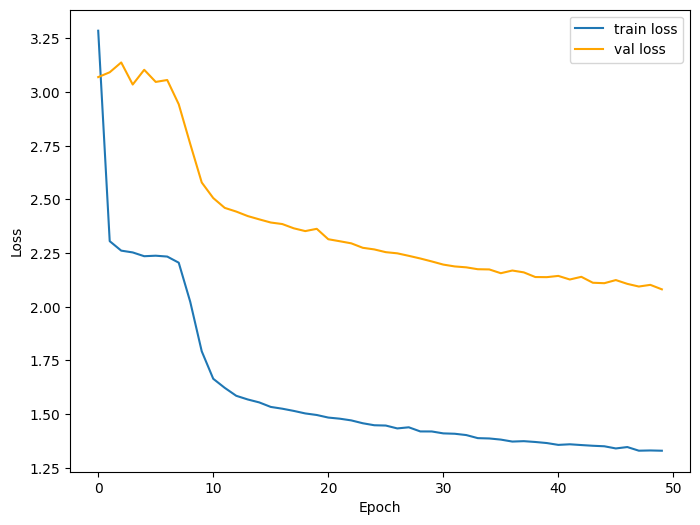

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()
print()

# Text generation

In [20]:
k = 3

In [21]:
text_generator = GenerateText(model, k, train_dataset.int2char, train_dataset.char2int, device)

In [22]:
test = input("Enter Text : ")

text_generator.generate_text(test)

Enter Text :  hi


'hioe]'

In [23]:
!pip install wikipedia
import wikipedia
page = wikipedia.page("Pet door")
print(page.content)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
The dog (Canis familiaris or Canis lupus familiaris) is a domesticated descendant of the gray wolf. Also called the domestic dog, it was selectively bred from an extinct population of wolves during the Late Pleistocene by hunter-gatherers. The dog was the first species to be domesticated by humans, over 14,000 years ago and before the development of agriculture. Due to their long association with humans, dogs have gained the ability to thrive on a starch-rich diet that would be inadequate for other canids.
Dogs have been bred for desired behaviors, sensory capabilities, and physical attributes. Dog breeds vary widely in shape, size, and color. They have the same number of bones (with the exception of the tail), powerful jaws that house around 42 teeth, and well-developed senses of smell, hearing, and sight. Compared to humans, dogs possess a superior sense of smell and heari